In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important; }</style>"))

In [2]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

import utils
from het_block import het
import simple_block as sim
from simple_block import simple
import jacobian as jac
# import nonlinear
import hank
# import determinacy as det

In [3]:
# Add Transfers function to households block
def transfers(pi_e, Div, Tax, e_grid, div_rule, tax_rule):    
    div = Div / np.sum(pi_e * div_rule) * div_rule
    tax = Tax / np.sum(pi_e * tax_rule) * tax_rule
    T = div - tax
    return T

household = hank.household.attach_hetinput(transfers)

In [4]:
# hank.household.inputs, hank.household.outputs, household.inputs

In [5]:
# e_grid, pi_e, Pi = utils.markov_rouwenhorst(rho=0.966, sigma=0.5, N=7)
# e_grid, np.sum(pi_e * e_grid), (1-1/1.2)*e_grid - 0.228*e_grid

In [42]:
# SS solver
def hank_ss(beta_guess=0.986, vphi_guess=0.8, r=0.005, eis=0.5, frisch=0.5, mu=1.2, B_Y=5.6, rho_s=0.966, sigma_s=0.5,
            kappa=0.1, phi=1, nS=7, amax=150, nA=500, tax_rule=None, div_rule=None, G=0.200, phiy=0.1):
    """Solve steady state of full GE model. Calibrate (beta, vphi) to hit target for interest rate and Y."""

    # set up grid
    a_grid = utils.agrid(amax=amax, n=nA)
    e_grid, pi_e, Pi = utils.markov_rouwenhorst(rho=rho_s, sigma=sigma_s, N=nS)
    
    # default incidence rules are proportional to skill
    if tax_rule is None:
        tax_rule = e_grid  # scale does not matter, will be normalized anyway
    if div_rule is None:
        div_rule = e_grid
    assert len(tax_rule) == len(div_rule) == len(e_grid), 'Incidence rules are inconsistent with income grid.'

    # solve analytically what we can
    B = B_Y
    w = 1 / mu
    Div = (1 - w)
    Tax = r * B + G
    T = transfers(pi_e, Div, Tax, e_grid, div_rule, tax_rule)

    # initialize guess for policy function iteration
    fininc = (1 + r) * a_grid + T[:, np.newaxis] - a_grid[0]
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis] + T[:, np.newaxis]
    Va = (1 + r) * (0.1 * coh) ** (-1 / eis)

    # residual function
    def res(x):
        beta_loc, vphi_loc = x
        # precompute constrained c and n which don't depend on Va
        c_const_loc, n_const_loc = hank.solve_cn(w * e_grid[:, np.newaxis], fininc, eis, frisch, vphi_loc, Va)
        if beta_loc > 0.999 / (1 + r) or vphi_loc < 0.001:
            raise ValueError('Clearly invalid inputs')
        out = household.ss(Va=Va, Pi=Pi, a_grid=a_grid, e_grid=e_grid, pi_e=pi_e, w=w, r=r, beta=beta_loc, eis=eis,
                           Div=Div, Tax=Tax, frisch=frisch, vphi=vphi_loc, c_const=c_const_loc, n_const=n_const_loc,
                           tax_rule=tax_rule, div_rule=div_rule, ssflag=True)
        return np.array([out['A'] - B, out['NS'] - 1])

    # solve for beta, vphi
    (beta, vphi), _ = utils.broyden_solver(res, np.array([beta_guess, vphi_guess]), noisy=False)

    # extra evaluation for reporting
    c_const, n_const = hank.solve_cn(w * e_grid[:, np.newaxis], fininc, eis, frisch, vphi, Va)
    ss = household.ss(Va=Va, Pi=Pi, a_grid=a_grid, e_grid=e_grid, pi_e=pi_e, w=w, r=r, beta=beta, eis=eis,
                      Div=Div, Tax=Tax, frisch=frisch, vphi=vphi, c_const=c_const, n_const=n_const,
                      tax_rule=tax_rule, div_rule=div_rule, ssflag=True)
    
    # check Walras's law
    walras = 1 - G - ss['C']
    assert np.abs(walras) < 1E-8
    
    # add aggregate variables
    ss.update({'B': B, 'phi': phi, 'kappa': kappa, 'Y': 1, 'rstar': r, 'Z': 1, 'mu': mu, 'L': 1, 'pi': 0,
               'walras': walras, 'ssflag': False, 'G': G, 'phiy': phiy, 'Bbar': B})
    return ss

In [43]:
# Get SS values
ss = hank_ss()
ss.keys()

dict_keys(['ssflag', 'frisch', 'c_const', 'e_grid', 'eis', 'T', 'w', 'r', 'vphi', 'a_grid', 'n_const', 'beta', 'Pi', 'Va', 'Tax', 'pi_e', 'div_rule', 'tax_rule', 'Div', 'a', 'c', 'n', 'ns', 'N', 'C', 'NS', 'A', 'D', 'B', 'phi', 'kappa', 'Y', 'rstar', 'Z', 'mu', 'L', 'pi', 'walras', 'G', 'phiy', 'Bbar'])

In [46]:
ss['G'], ss['Tax'], ss['r'], ss['B'], ss['Tax']-ss['B']*ss['r'], ss['C'], ss['Bbar']

(0.2, 0.228, 0.005, 5.6, 0.2, 0.8000000055130119, 5.6)

In [21]:
# Simple blocks - Benchmark
@simple
def firm(Y, w, Z, pi, mu, kappa):
    L = Y / Z
    Div = Y - w * L - mu/(mu-1)/(2*kappa) * np.log(1+pi)**2 * Y
    return L, Div

@simple
# def monetary(rstar):
def monetary(pi, rstar, phi):
    r = (1 + rstar(-1) + phi * pi(-1)) / (1 + pi) - 1 #(Fisher + Taylor)
    return r

@simple
def debt()
@simple
def fiscal(r, B, G):
    Tax = r * B + G #T = fixed_T + phit * (B(-1) - B)
    return Tax

@simple
def mkt_clearing(A, NS, C, L, Y, B, pi, mu, kappa, G):
    asset_mkt = A - B
    labor_mkt = NS - L
    goods_mkt = Y - C - mu/(mu-1)/(2*kappa) * np.log(1+pi)**2 * Y - G #(G=0 here!) 
    return asset_mkt, labor_mkt, goods_mkt

@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * np.log(1 + pi(+1)) / (1 + r(+1)) - np.log(1 + pi)
    return nkpc_res

In [22]:
T = 300
exogenous = ['rstar', 'Z', 'G', 'B']
unknowns = ['pi', 'w', 'Y']
targets = ['nkpc_res', 'asset_mkt', 'labor_mkt']
block_list = [firm, monetary, fiscal, nkpc, mkt_clearing, household]
# outputs=['Y', 'G', 'r']

In [ ]:
# PE results to see what's up
curlyJs, required = jac.curlyJ_sorted(block_list, unknowns + exogenous, ss, T,
                                      save=False, use_saved=False)

In [ ]:
J_curlyH_U = jac.forward_accumulate(curlyJs, unknowns, targets, required)
J_curlyH_Z = jac.forward_accumulate(curlyJs, exogenous, targets, required)
H_U = jac.pack_jacobians(J_curlyH_U, unknowns, targets, T)
H_Z = jac.pack_jacobians(J_curlyH_Z, exogenous, targets, T)
G_U = jac.unpack_jacobians(-np.linalg.solve(H_U, H_Z), exogenous, unknowns, T)

In [ ]:
J = jac.forward_accumulate(curlyJs, unknowns +exogenous)

In [ ]:
drstar = -0.0025 * 0.5 ** (np.arange(T)[:, np.newaxis])

dr = J['r']['rstar'] @ drstar
dC = J['C']['rstar'] @ drstar
dTax = J['Tax']['rstar'] @ drstar
dA = J['A']['rstar'] @ drstar
dNS = J['NS']['rstar'] @ drstar
da_mkt = J['asset_mkt']['rstar'] @ drstar
dl_mkt = J['labor_mkt']['rstar'] @ drstar
dg_mkt = J['goods_mkt']['rstar'] @ drstar
dpi = G_U['pi']['rstar'] @ drstar
dw = G_U['w']['rstar'] @ drstar
dY = G_U['Y']['rstar'] @ drstar
daa_mkt = J_curlyH_Z['asset_mkt']['rstar'] @ drstar
dll_mkt = J_curlyH_Z['labor_mkt']['rstar'] @ drstar

dG = dTax - dr*ss['B'] 

fig = plt.figure(figsize = (15, 3))
ax = fig.add_subplot(1, 6, 1)
ax.plot(10000 * drstar[:21])
ax.set_title('Shock to rstar')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(1, 6, 2)
ax.plot(10000 * dr[:21])
ax.set_title('r')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(1, 6, 3)
ax.plot(10000 * dC[:21])
ax.set_title('C')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(1, 6, 4)
ax.plot(10000 * dTax[:21])
ax.set_title('Tax')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(1, 6, 5)
ax.plot(10000 * dA[:21])
ax.set_title('A')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
# ax = fig.add_subplot(1, 6, 6)
# ax.plot(10000 * dDiv[:21])
# ax.set_title('Div')
# ax.set_xlabel('quarters')
# ax.set_ylabel('bp deviation from ss')

fig = plt.figure(figsize = (15, 3))
ax = fig.add_subplot(1, 5, 1)
ax.plot(10000 * dNS[:21])
ax.set_title('NS')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(1, 5, 2)
ax.plot(10000 * dG[:21])
ax.set_title('G')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(1, 5, 3)
ax.plot(10000 * da_mkt[:21])
ax.set_title('A_MK')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(1, 5, 4)
ax.plot(10000 * dl_mkt[:21])
ax.set_title('L_MK')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(1, 5, 5)
ax.plot(10000 * dg_mkt[:21])
ax.set_title('G_MK')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')

fig = plt.figure(figsize = (15, 3))
ax = fig.add_subplot(1, 6, 1)
ax.plot(10000 * dpi[:21])
ax.set_title('Pi')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(1, 6, 2)
ax.plot(10000 * dw[:21])
ax.set_title('w')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(1, 6, 3)
ax.plot(10000 * dY[:21])
ax.set_title('Y')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(1, 6, 4)
ax.plot(10000 * daa_mkt[:21])
ax.set_title('AA_MK')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(1, 6, 5)
ax.plot(10000 * dll_mkt[:21])
ax.set_title('LL_MK')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')

In [23]:
# general equilibrium jacobians
block_list = [firm, monetary, fiscal, nkpc, mkt_clearing, household] 
G = jac.get_G(block_list, exogenous, unknowns, targets, T, ss, save=True)

Text(0, 0.5, 'bp deviation from ss')

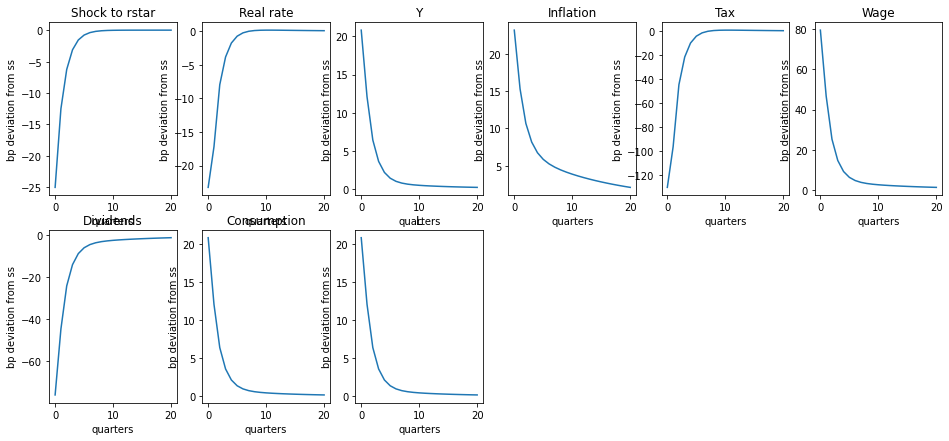

In [24]:
# Some charts: expansionary MP shock
drstar = -0.0025 * 0.5 ** (np.arange(T)[:, np.newaxis])

dr = G['r']['rstar'] @ drstar
dY = G['Y']['rstar'] @ drstar
dpi = G['pi']['rstar'] @ drstar
dTax = G['Tax']['rstar'] @ drstar
dw = G['w']['rstar'] @ drstar
dDiv = G['Div']['rstar'] @ drstar
dC = G['C']['rstar'] @ drstar
dL = G['L']['rstar'] @ drstar
# dmk = G['goods_mkt']['rstar'] @ drstar

# dend_drstar = {}
fig = plt.figure(figsize = (16, 7))
ax = fig.add_subplot(2, 6, 1)
ax.plot(10000 * drstar[:21])
ax.set_title('Shock to rstar')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(2, 6, 2)
ax.plot(10000 * dr[:21])
ax.set_title(r'Real rate')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(2, 6, 3)
ax.plot(10000 * dY[:21])
ax.set_title(r'Y')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(2, 6, 4)
ax.plot(10000 * dpi[:21])
ax.set_title(r'Inflation')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(2, 6, 5)
ax.plot(10000 * dTax[:21])
ax.set_title(r'Tax')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(2, 6, 6)
ax.plot(10000 * dw[:21])
ax.set_title(r'Wage')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(2, 6, 7)
ax.plot(10000 * dDiv[:21])
ax.set_title(r'Dividends')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(2, 6, 8)
ax.plot(10000 * dC[:21])
ax.set_title(r'Consumption')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(2, 6, 9)
ax.plot(10000 * dL[:21])
ax.set_title(r'L')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
# ax = fig.add_subplot(3, 4, 10)
# ax.plot(10000 * dmk[:21])
# ax.set_title(r'MK')
# ax.set_xlabel('quarters')
# ax.set_ylabel('bp deviation from ss')

In [ ]:
ss['B'] * ss['r'] + ss['G'] - ss['Tax'], ss['Tax']

In [ ]:
G.keys()

In [ ]:
ss['Y'], ss['B'], ss['r'], (dB * ss['r'] - dTax_b)[:12], dTax_b[:12]

In [ ]:
G.keys()

In [16]:
G['r'].keys()

dict_keys(['rstar', 'Z', 'G', 'B'])

Text(0, 0.5, 'bp deviation from ss')

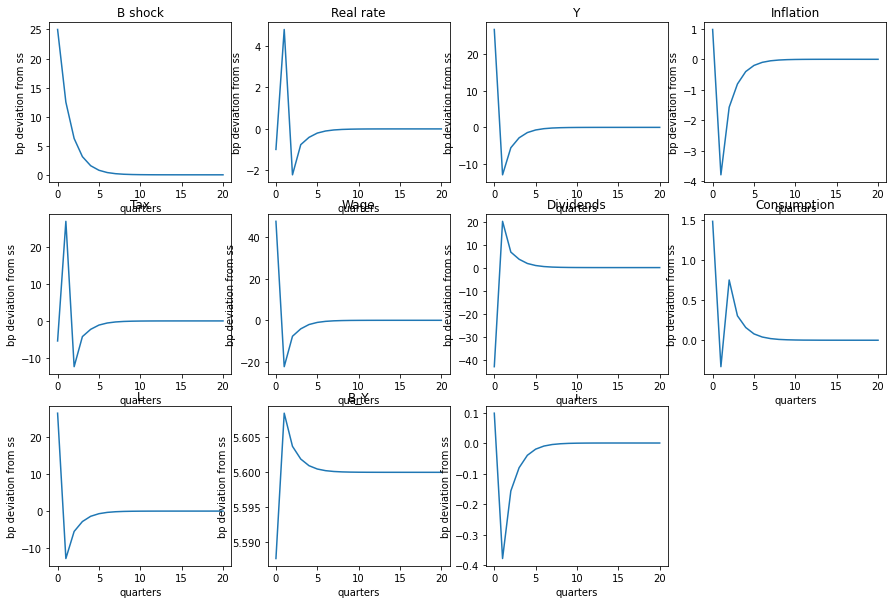

In [25]:
# Some charts: B shock
dB = 0.0025 * 0.5 ** (np.arange(T)[:, np.newaxis])

dr_b = G['r']['B'] @ dB
dY_b = G['Y']['B'] @ dB
dpi_b = G['pi']['B'] @ dB
dTax_b = G['Tax']['B'] @ dB
dw_b = G['w']['B'] @ dB
dDiv_b = G['Div']['B'] @ dB
dC_b = G['C']['B'] @ dB
dL_b = G['L']['B'] @ dB
dB_Y = (ss['B'] + dB) / (ss['Y'] + G['Y']['B'] @ dB)
di_b = (1 ) * (1 + dpi_b) - 1

# dend_drstar = {}
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(3, 4, 1)
ax.plot(10000 * dB[:21])
ax.set_title('B shock')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 2)
ax.plot(10000 * dr_b[:21])
ax.set_title(r'Real rate')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 3)
ax.plot(10000 * dY_b[:21])
ax.set_title(r'Y')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 4)
ax.plot(10000 * dpi_b[:21])
ax.set_title(r'Inflation')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 5)
ax.plot(10000 * dTax_b[:21])
ax.set_title(r'Tax')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 6)
ax.plot(10000 * dw_b[:21])
ax.set_title(r'Wage')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 7)
ax.plot(10000 * dDiv_b[:21])
ax.set_title(r'Dividends')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 8)
ax.plot(10000 * dC_b[:21])
ax.set_title(r'Consumption')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 9)
ax.plot(10000 * dL_b[:21])
ax.set_title(r'L')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 10)
ax.plot(dB_Y[:21])
ax.set_title(r'B_Y')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 11)
ax.plot(1000 * di_b[:21])
ax.set_title(r'i')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')

In [32]:
(G['A']['B'] @ dB)[:5]- dB[:5], G.keys()

(array([[ 0.00000000e+00],
        [ 1.30104261e-18],
        [ 5.42101086e-19],
        [-5.42101086e-19],
        [ 1.54498810e-18]]),
 dict_keys(['A', 'pi', 'goods_mkt', 'Tax', 'L', 'r', 'NS', 'w', 'Div', 'Y', 'C', 'N']))

In [41]:
dY_b[0], dC_b[0] +ss['mu']/(ss['mu']-1)/(2*ss['kappa']) * np.log(1+dpi_b[0])**2 *dY_b[0]

(array([0.00266023]), array([0.00014795]))

Text(0, 0.5, 'bp deviation from ss')

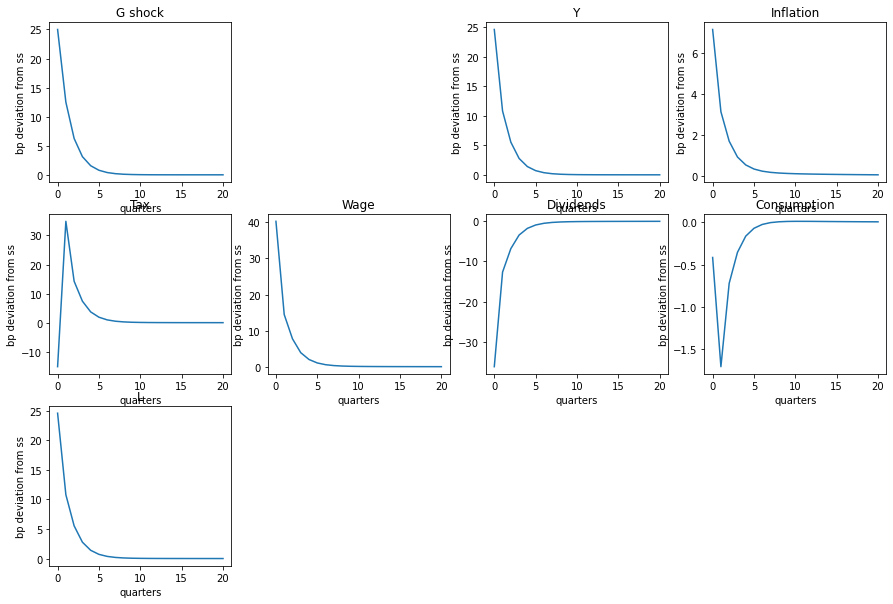

In [48]:
# Some charts: expansionary MP shock
dG = 0.0025 * 0.5 ** (np.arange(T)[:, np.newaxis])

# dr_g = G['r']['G'] @ dG
dY_g = G['Y']['G'] @ dG
dpi_g = G['pi']['G'] @ dG
dTax_g = G['Tax']['G'] @ dG
dw_g = G['w']['G'] @ dG
dDiv_g = G['Div']['G'] @ dG
dC_g = G['C']['G'] @ dG
dL_g = G['L']['G'] @ dG

# dend_drstar = {}
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(3, 4, 1)
ax.plot(10000 * dG[:21])
ax.set_title('G shock')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
# ax = fig.add_subplot(3, 4, 2)
# ax.plot(10000 * dr_g[:21])
# ax.set_title(r'Real rate')
# ax.set_xlabel('quarters')
# ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 3)
ax.plot(10000 * dY_g[:21])
ax.set_title(r'Y')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 4)
ax.plot(10000 * dpi_g[:21])
ax.set_title(r'Inflation')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 5)
ax.plot(10000 * dTax_g[:21])
ax.set_title(r'Tax')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 6)
ax.plot(10000 * dw_g[:21])
ax.set_title(r'Wage')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 7)
ax.plot(10000 * dDiv_g[:21])
ax.set_title(r'Dividends')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 8)
ax.plot(10000 * dC_g[:21])
ax.set_title(r'Consumption')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 9)
ax.plot(10000 * dL_g[:21])
ax.set_title(r'L')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
# ax = fig.add_subplot(3, 4, 10)
# ax.plot(10000 * dL[:21])
# ax.set_title(r'L')
# ax.set_xlabel('quarters')
# ax.set_ylabel('bp deviation from ss')

In [ ]:
ss['kappa']

In [ ]:
dG[0], dY_g[0], dC_g[0], dG[0] + dC_g[0],  (dG[0] + dC_g[0])+1.2/(1.2-1)/(2*0.1) * np.log(1+dpi_g[0])**2 * dY_g[0]

In [ ]:
dG[0], dY[0], dC[0], dG[0] + dC[0], (dG[0] + dC[0])/ (1- 1.2/(1.2-1)/(2*0.1) * np.log(1+dpi[0])**2)

In [ ]:
((1000*dw_g*1000*dL_g * e_grid/pi_e)[:5,:] + ((1000*dDiv_g* e_grid/pi_e - 1000*dTax_g* e_grid/pi_e)[:5,:]))[:,4]

In [ ]:
((1000*dw_g*1000*dL_g * e_grid/pi_e)[:5,:] + ((1000*dDiv_g* e_grid/pi_e - 1000*dTax_g* e_grid/pi_e)[:5,:]))[:,0]

In [ ]:
((1000*dw_g*1000*dL_g)[:5,:] + ((1000*dDiv_g - 1000*dTax_g)[:5,:]))

In [ ]:
# What happens to labor income for different productivity shocks
((dw_g*e_grid)[:5,:] + ((dDiv_g - dTax_g) * e_grid)[:5,:])[:,0]

In [53]:
G['r'].keys()

dict_keys(['rstar', 'Z', 'G', 'B'])

Text(0, 0.5, 'bp deviation from ss')

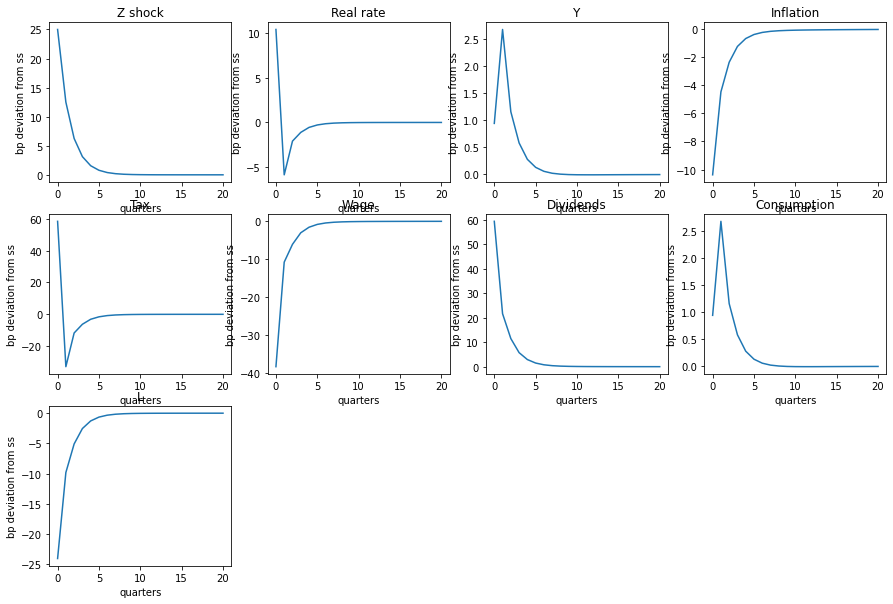

In [54]:
# Some charts: expansionary MP shock
dZ = 0.0025 * 0.5 ** (np.arange(T)[:, np.newaxis])

dr_z = G['r']['Z'] @ dZ
dY_z = G['Y']['Z'] @ dZ
dpi_z = G['pi']['Z'] @ dZ
dTax_z = G['Tax']['Z'] @ dZ
dw_z = G['w']['Z'] @ dZ
dDiv_z = G['Div']['Z'] @ dZ
dC_z = G['C']['Z'] @ dZ
dL_z = G['L']['Z'] @ dZ

# dend_drstar = {}
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(3, 4, 1)
ax.plot(10000 * dZ[:21])
ax.set_title('Z shock')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 2)
ax.plot(10000 * dr_z[:21])
ax.set_title(r'Real rate')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 3)
ax.plot(10000 * dY_z[:21])
ax.set_title(r'Y')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 4)
ax.plot(10000 * dpi_z[:21])
ax.set_title(r'Inflation')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 5)
ax.plot(10000 * dTax_z[:21])
ax.set_title(r'Tax')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 6)
ax.plot(10000 * dw_z[:21])
ax.set_title(r'Wage')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 7)
ax.plot(10000 * dDiv_z[:21])
ax.set_title(r'Dividends')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 8)
ax.plot(10000 * dC_z[:21])
ax.set_title(r'Consumption')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 9)
ax.plot(10000 * dL_z[:21])
ax.set_title(r'L')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
# ax = fig.add_subplot(3, 4, 10)
# ax.plot(10000 * dL[:21])
# ax.set_title(r'L')
# ax.set_xlabel('quarters')
# ax.set_ylabel('bp deviation from ss')

In [ ]:
ss['phi']=1

In [ ]:
ss['phiy']=0

In [ ]:
@simple
def monetary(pi, rstar, phi, phiy, Y):
    r = (1 + rstar(-1) + phi * pi(-1) + phiy * (Y(-1) - 1)) / (1 + pi) - 1 #(Fisher + Taylor)
    return r

# general equilibrium jacobians
block_list = [firm, monetary, fiscal, nkpc, mkt_clearing, household] 
G_og = jac.get_G(block_list, exogenous, unknowns, targets, T, ss, save=True)

In [ ]:
G_og['r'].keys()

In [ ]:
# Some charts: expansionary MP shock
dr_og = G_og['r']['rstar'] @ drstar
dY_og = G_og['Y']['rstar'] @ drstar
dpi_og = G_og['pi']['rstar'] @ drstar
dTax_og = G_og['Tax']['rstar'] @ drstar
dw_og = G_og['w']['rstar'] @ drstar
dDiv_og = G_og['Div']['rstar'] @ drstar
dC_og = G_og['C']['rstar'] @ drstar
dL_og = G_og['L']['rstar'] @ drstar

# dend_drstar = {}
fig = plt.figure(figsize = (16, 7))
ax = fig.add_subplot(2, 6, 1)
ax.plot(10000 * drstar[:21])
ax.set_title('Shock to rstar')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(2, 6, 2)
ax.plot(10000 * dr[:21], label='bmk')
ax.plot(10000 * dr_og[:21])
ax.set_title(r'Real rate')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax.legend()
ax = fig.add_subplot(2, 6, 3)
ax.plot(10000 * dY[:21], label='bmk')
ax.plot(10000 * dY_og[:21])
ax.set_title(r'Y')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax.legend()
ax = fig.add_subplot(2, 6, 4)
ax.plot(10000 * dpi[:21], label='bmk')
ax.plot(10000 * dpi_og[:21])
ax.set_title(r'Inflation')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax.legend()
ax = fig.add_subplot(2, 6, 5)
ax.plot(10000 * dTax[:21], label='bmk')
ax.plot(10000 * dTax_og[:21])
ax.set_title(r'Tax')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax.legend()
ax = fig.add_subplot(2, 6, 6)
ax.plot(10000 * dw[:21], label='bmk')
ax.plot(10000 * dw_og[:21])
ax.set_title(r'Wage')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax.legend()
ax = fig.add_subplot(2, 6, 7)
ax.plot(10000 * dDiv[:21], label='bmk')
ax.plot(10000 * dDiv_og[:21])
ax.set_title(r'Dividends')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax.legend()
ax = fig.add_subplot(2, 6, 8)
ax.plot(10000 * dC[:21], label='bmk')
ax.plot(10000 * dC_og[:21])
ax.set_title(r'Consumption')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax.legend()
ax = fig.add_subplot(2, 6, 9)
ax.plot(10000 * dL[:21], label='bmk')
ax.plot(10000 * dL_og[:21])
ax.set_title(r'L')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax.legend()

In [ ]:
# Some charts: expansionary MP shock
dr_g_og = G_og['r']['G'] @ dG
dY_g_og = G_og['Y']['G'] @ dG
dpi_g_og = G_og['pi']['G'] @ dG
dTax_g_og = G_og['Tax']['G'] @ dG
dw_g_og = G_og['w']['G'] @ dG
dDiv_g_og = G_og['Div']['G'] @ dG
dC_g_og = G_og['C']['G'] @ dG
dL_g_og = G_og['L']['G'] @ dG

# dend_drstar = {}
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(3, 4, 1)
ax.plot(10000 * dG[:21])
ax.set_title('G shock')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 2)
# ax.plot(10000 * dr_g[:21], label='bmk')
ax.plot(10000 * dr_g_og[:21])
ax.set_title(r'Real rate')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax.legend()
ax = fig.add_subplot(3, 4, 3)
ax.plot(10000 * dY_g[:21], label='bmk')
ax.plot(10000 * dY_g_og[:21])
ax.set_title(r'Y')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax.legend()
ax = fig.add_subplot(3, 4, 4)
ax.plot(10000 * dpi_g[:21], label='bmk')
ax.plot(10000 * dpi_g_og[:21])
ax.set_title(r'Inflation')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax.legend()
ax = fig.add_subplot(3, 4, 5)
ax.plot(10000 * dTax_g[:21], label='bmk')
ax.plot(10000 * dTax_g_og[:21])
ax.set_title(r'Tax')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax.legend()
ax = fig.add_subplot(3, 4, 6)
ax.plot(10000 * dw_g[:21], label='bmk')
ax.plot(10000 * dw_g_og[:21])
ax.set_title(r'Wage')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 7)
ax.plot(10000 * dDiv_g[:21], label='bmk')
ax.plot(10000 * dDiv_g_og[:21])
ax.set_title(r'Dividends')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax.legend()
ax = fig.add_subplot(3, 4, 8)
ax.plot(10000 * dC_g[:21], label='bmk')
ax.plot(10000 * dC_g_og[:21])
ax.set_title(r'Consumption')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax.legend()
ax = fig.add_subplot(3, 4, 9)
ax.plot(10000 * dL_g[:21], label='bmk')
ax.plot(10000 * dL_g_og[:21])
ax.set_title(r'L')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax.legend()
# ax = fig.add_subplot(3, 4, 10)
# ax.plot(10000 * dL[:21])
# ax.set_title(r'L')
# ax.set_xlabel('quarters')
# ax.set_ylabel('bp deviation from ss')

In [ ]:
combined_asset_dist = combined_dist*ss['a_grid']/ss['A']
cumulative_dist = combined_dist.cumsum()
cumulative_asset_dist = combined_asset_dist.cumsum()

cumulative_dist = np.concatenate(([0], cumulative_dist))
cumulative_asset_dist = np.concatenate(([0], cumulative_asset_dist))

under_curve = np.trapz(cumulative_asset_dist, cumulative_dist)
gini = 1-2*under_curve

fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot(1, 2, 2)
ax.plot(cumulative_dist, cumulative_asset_dist, linewidth=2, label=f'Gini = {gini:.2f}')
ax.plot(cumulative_dist, cumulative_dist, '--')
ax.set_xlabel('Cumulative share of households')
ax.set_ylabel('Cumulative share of assets')
ax.set_title('Lorenz curve for assets')
ax.legend(framealpha=0)
ax = fig.add_subplot(1, 2, 1)
combined_dist = ss['D'].sum(0)
ax.hist(ss['a_grid'], bins=20, range=(0, 4), weights=combined_dist)
ax.set_xlabel('Assets');
ax.set_ylabel('Frequency')
ax.set_title('Histogram of asset distribution')

In [ ]:
fig = plt.figure(figsize = (4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(10000 * (G['C']['G'] @ dG)[:21])
ax.set_title('Shock to rstar')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')

In [ ]:
G['A']['G'].shape

In [ ]:
drstar.shape